### Import libraries

In [2]:
import os

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet121

import numpy as np


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data processing

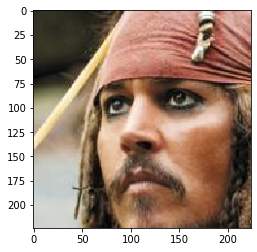

In [4]:
def get_image(filename):
    ########################################################################
    # TODO: Your code here...
    ########################################################################
    image = load_img(filename, target_size=(224, 224))
    np_image = img_to_array(image)
    return np_image


import matplotlib.pyplot as plt
%matplotlib inline

image = get_image('./affectnet/train_class/class001/image0012399.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [4]:
!ls -a './affectnet/train_class'
!ls -a './affectnet/val_class'

.  ..  class001  class002  class003
.  ..  class001  class002  class003


In [6]:
# data augmentation
train_data_gen= ImageDataGenerator(rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        ) # change to biliear
validation_data_gen=ImageDataGenerator(rescale=1./255)

# train and validation directory
train_dir="./affectnet/train_class"
val_dir="./affectnet/val_class"

bs=64
cm="categorical"

train_gen=train_data_gen.flow_from_directory(train_dir,target_size=(224,224),batch_size=bs,class_mode=cm)
val_gen=validation_data_gen.flow_from_directory(val_dir,target_size=(224,224),batch_size=bs,class_mode=cm)

Found 15000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


### Model

In [7]:
# CNN sequencial model
def create_model(opt, input_tensor, kernel_initializer='he_normal', trained_layers=15):
    model_densenet= DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    top_model = Sequential()
    top_model.add(Flatten())
    top_model.add(Dense(512, activation='relu',kernel_initializer=kernel_initializer))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.2))    
   # top_model.add(Dense(128, activation='relu'))
    #top_model.add(BatchNormalization())
    #top_model.add(Dropout(0.2))
    top_model.add(Dense(3, activation='softmax'))   # 7 classes

    # Connect vgg16 and top_model
    model = Model(inputs = model_densenet.input, outputs = top_model(model_densenet.output))

    fixed_layers = -1 * trained_layers
    # Fix layers
    for layer in model.layers[:fixed_layers]:
        layer.trainable = False
    

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #model.summary()
    
    return model

In [8]:
def fit_model(model,bs,epoch,model_name):
    no_train_img=15000
    no_val_img=1500
    epochs=epoch
    batch_size=bs

    #early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
    #early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)

    h=model.fit(
           train_gen,
            steps_per_epoch=no_train_img // batch_size,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=no_val_img // batch_size,
            #callbacks=[early_stop],
             verbose=1
            )
    model.save(model_name)

    
    return h

### Comparison between glorot_uniform and he_normal kernel initializer

Default Adam optimizer values. Kernel optimizer changed
Epoch 1/15
234/234 [==============================] - 442s 2s/step - loss: 0.8612 - accuracy: 0.6498 - val_loss: 0.6928 - val_accuracy: 0.6978
Epoch 2/15
234/234 [==============================] - 432s 2s/step - loss: 0.6051 - accuracy: 0.7350 - val_loss: 0.6543 - val_accuracy: 0.7312
Epoch 3/15
234/234 [==============================] - 430s 2s/step - loss: 0.5418 - accuracy: 0.7638 - val_loss: 0.5995 - val_accuracy: 0.7465
Epoch 4/15
234/234 [==============================] - 429s 2s/step - loss: 0.5023 - accuracy: 0.7806 - val_loss: 0.7594 - val_accuracy: 0.6978
Epoch 5/15
234/234 [==============================] - 435s 2s/step - loss: 0.4617 - accuracy: 0.8018 - val_loss: 0.5795 - val_accuracy: 0.7597
Epoch 6/15
234/234 [==============================] - 433s 2s/step - loss: 0.4310 - accuracy: 0.8160 - val_loss: 0.6586 - val_accuracy: 0.7361
Epoch 7/15
234/234 [==============================] - 433s 2s/step - loss: 0.3928 - ac

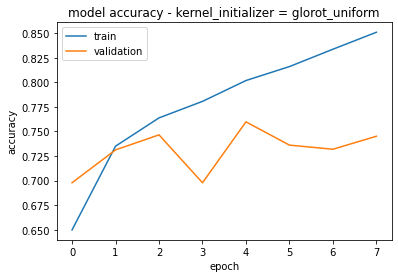

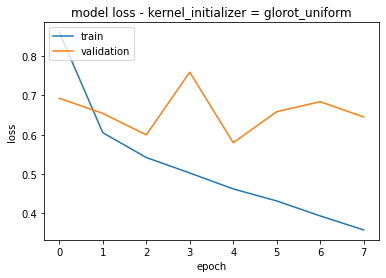

Epoch 1/15
234/234 [==============================] - 436s 2s/step - loss: 0.8596 - accuracy: 0.6470 - val_loss: 0.6249 - val_accuracy: 0.7145
Epoch 2/15
234/234 [==============================] - 432s 2s/step - loss: 0.6048 - accuracy: 0.7300 - val_loss: 0.7651 - val_accuracy: 0.6790
Epoch 3/15
234/234 [==============================] - 433s 2s/step - loss: 0.5424 - accuracy: 0.7665 - val_loss: 0.5913 - val_accuracy: 0.7451
Epoch 4/15
234/234 [==============================] - 436s 2s/step - loss: 0.4988 - accuracy: 0.7825 - val_loss: 0.6863 - val_accuracy: 0.7354
Epoch 5/15
234/234 [==============================] - 435s 2s/step - loss: 0.4500 - accuracy: 0.8082 - val_loss: 0.6354 - val_accuracy: 0.7375
Epoch 6/15
234/234 [==============================] - 434s 2s/step - loss: 0.4237 - accuracy: 0.8202 - val_loss: 0.5843 - val_accuracy: 0.7597
Epoch 7/15
131/234 [===============>..............] - ETA: 2:57 - loss: 0.3637 - accuracy: 0.8466

In [ ]:
kernel_initializers = ['glorot_uniform', 'he_normal']
epoch = 10
input_tensor=Input(shape=(224,224,3))
print('Default Adam optimizer values. Kernel optimizer changed')

for ki in kernel_initializers:  
    model_name = 'model_' + ki 
    opt = keras.optimizers.Adam() # default settings
    model=create_model(opt,input_tensor)
    hs=fit_model(model, bs, epoch, model_name)
    plt.plot(hs.history['accuracy'])
    plt.plot(hs.history['val_accuracy'])
    plt.title('model accuracy - kernel_initializer = {}'.format(ki))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hs.history['loss'])
    plt.plot(hs.history['val_loss'])
    plt.title('model loss - kernel_initializer = {}'.format(ki))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Default Adam optimizer values. Kernel optimizer changed
Epoch 1/10
234/234 [==============================] - 423s 2s/step - loss: 0.8650 - accuracy: 0.6436 - val_loss: 0.6204 - val_accuracy: 0.7228
Epoch 2/10
234/234 [==============================] - 419s 2s/step - loss: 0.6071 - accuracy: 0.7276 - val_loss: 0.5783 - val_accuracy: 0.7480
Epoch 3/10
234/234 [==============================] - 416s 2s/step - loss: 0.5471 - accuracy: 0.7622 - val_loss: 0.7319 - val_accuracy: 0.6895
Epoch 4/10
234/234 [==============================] - 416s 2s/step - loss: 0.5044 - accuracy: 0.7803 - val_loss: 0.5900 - val_accuracy: 0.7561
Epoch 5/10
234/234 [==============================] - 412s 2s/step - loss: 0.4683 - accuracy: 0.7967 - val_loss: 0.6605 - val_accuracy: 0.7289
Epoch 00005: early stopping


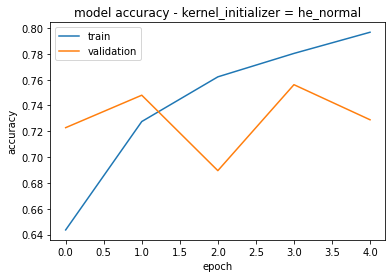

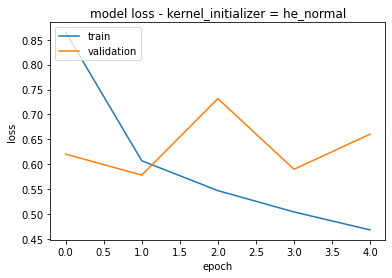

In [13]:
kernel_initializers = ['he_normal']
epoch = 10
lr = 0.001
input_tensor=Input(shape=(224,224,3))
print('Default Adam optimizer values. Kernel optimizer changed')
for ki in kernel_initializers:    
    model_name = 'model_' + ki 
    opt = keras.optimizers.Adam() # default settings
    model=create_model(opt,input_tensor)
    hs=fit_model(model, bs, epoch, model_name)
    
    plt.plot(hs.history['accuracy'])
    plt.plot(hs.history['val_accuracy'])
    plt.title('model accuracy - kernel_initializer = {}'.format(ki))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hs.history['loss'])
    plt.plot(hs.history['val_loss'])
    plt.title('model loss - kernel_initializer = {}'.format(ki))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

### Playing with various learning rates

Default Adam optimizer values. Default Dense layer kernel Initializer. Varying learning rates.
Epoch 1/25
234/234 [==============================] - 412s 2s/step - loss: 1.0019 - accuracy: 0.6201 - val_loss: 0.8317 - val_accuracy: 0.6852
Epoch 2/25
234/234 [==============================] - 415s 2s/step - loss: 0.7446 - accuracy: 0.6855 - val_loss: 0.8606 - val_accuracy: 0.6602
Epoch 3/25
234/234 [==============================] - 408s 2s/step - loss: 0.6337 - accuracy: 0.7267 - val_loss: 0.6643 - val_accuracy: 0.7194
Epoch 4/25
234/234 [==============================] - 410s 2s/step - loss: 0.5942 - accuracy: 0.7458 - val_loss: 0.6913 - val_accuracy: 0.7103
Epoch 5/25
234/234 [==============================] - 408s 2s/step - loss: 0.5435 - accuracy: 0.7671 - val_loss: 1.5462 - val_accuracy: 0.6490
Epoch 6/25
234/234 [==============================] - 413s 2s/step - loss: 0.4994 - accuracy: 0.7886 - val_loss: 0.6215 - val_accuracy: 0.7368
Epoch 7/25
234/234 [===========================

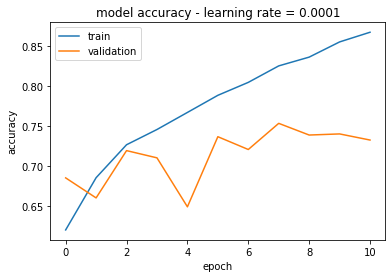

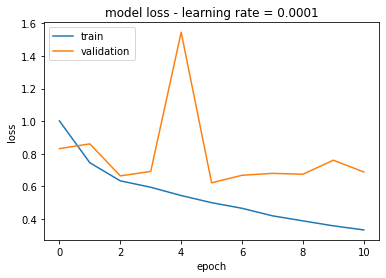

Epoch 1/25
234/234 [==============================] - 409s 2s/step - loss: 0.8310 - accuracy: 0.6501 - val_loss: 0.6967 - val_accuracy: 0.6943
Epoch 2/25
234/234 [==============================] - 409s 2s/step - loss: 0.6145 - accuracy: 0.7224 - val_loss: 0.6764 - val_accuracy: 0.7075
Epoch 3/25
234/234 [==============================] - 405s 2s/step - loss: 0.5289 - accuracy: 0.7698 - val_loss: 0.7391 - val_accuracy: 0.7040
Epoch 4/25
234/234 [==============================] - 410s 2s/step - loss: 0.4925 - accuracy: 0.7889 - val_loss: 0.6084 - val_accuracy: 0.7403
Epoch 5/25
234/234 [==============================] - 408s 2s/step - loss: 0.4591 - accuracy: 0.8050 - val_loss: 0.6389 - val_accuracy: 0.7416
Epoch 6/25
234/234 [==============================] - 406s 2s/step - loss: 0.4124 - accuracy: 0.8257 - val_loss: 0.6613 - val_accuracy: 0.7597
Epoch 7/25
234/234 [==============================] - 406s 2s/step - loss: 0.3865 - accuracy: 0.8402 - val_loss: 0.6909 - val_accuracy: 0.7570

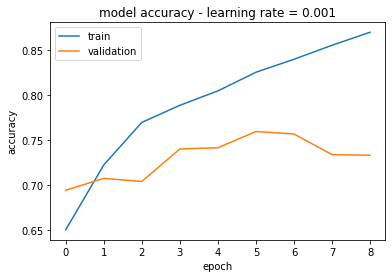

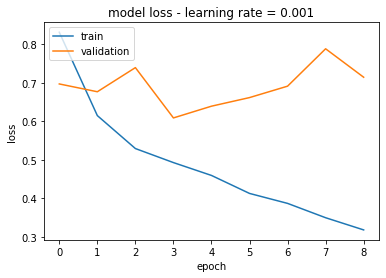

Epoch 1/25
234/234 [==============================] - 426s 2s/step - loss: 0.8209 - accuracy: 0.6519 - val_loss: 0.6660 - val_accuracy: 0.7201
Epoch 2/25
234/234 [==============================] - 423s 2s/step - loss: 0.6272 - accuracy: 0.7252 - val_loss: 0.5728 - val_accuracy: 0.7305
Epoch 3/25
234/234 [==============================] - 423s 2s/step - loss: 0.5473 - accuracy: 0.7599 - val_loss: 0.7296 - val_accuracy: 0.6873
Epoch 4/25
234/234 [==============================] - 432s 2s/step - loss: 0.5188 - accuracy: 0.7756 - val_loss: 0.6277 - val_accuracy: 0.7312
Epoch 5/25
234/234 [==============================] - 444s 2s/step - loss: 0.4974 - accuracy: 0.7849 - val_loss: 0.6133 - val_accuracy: 0.7270
Epoch 6/25
234/234 [==============================] - 446s 2s/step - loss: 0.4725 - accuracy: 0.8010 - val_loss: 0.6461 - val_accuracy: 0.7458
Epoch 7/25
234/234 [==============================] - 440s 2s/step - loss: 0.4559 - accuracy: 0.8046 - val_loss: 0.6215 - val_accuracy: 0.7514

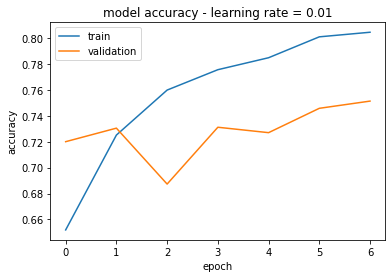

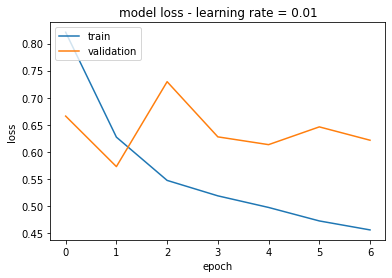

Epoch 1/25
234/234 [==============================] - 452s 2s/step - loss: 1.1386 - accuracy: 0.6214 - val_loss: 0.6493 - val_accuracy: 0.7103
Epoch 2/25
234/234 [==============================] - 436s 2s/step - loss: 0.6945 - accuracy: 0.7005 - val_loss: 0.7741 - val_accuracy: 0.7054
Epoch 3/25
234/234 [==============================] - 433s 2s/step - loss: 0.6904 - accuracy: 0.7035 - val_loss: 0.7599 - val_accuracy: 0.6929
Epoch 4/25
234/234 [==============================] - 446s 2s/step - loss: 0.7219 - accuracy: 0.7108 - val_loss: 0.8824 - val_accuracy: 0.7006
Epoch 5/25
234/234 [==============================] - 469s 2s/step - loss: 0.7873 - accuracy: 0.7017 - val_loss: 0.6075 - val_accuracy: 0.7597
Epoch 6/25
234/234 [==============================] - 438s 2s/step - loss: 0.6821 - accuracy: 0.7259 - val_loss: 0.7276 - val_accuracy: 0.7187
Epoch 7/25
234/234 [==============================] - 436s 2s/step - loss: 0.6936 - accuracy: 0.7290 - val_loss: 0.6769 - val_accuracy: 0.7416

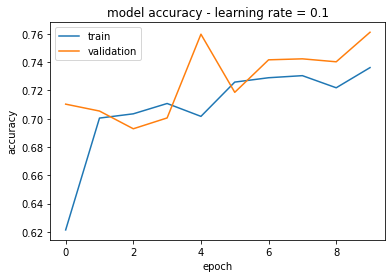

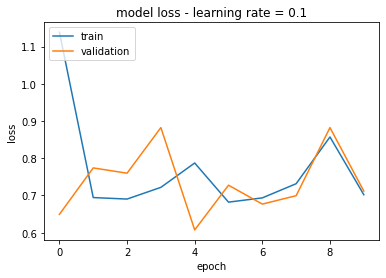

In [38]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epoch = 25
input_tensor=Input(shape=(224,224,3))
print('Default Adam optimizer values. Default Dense layer kernel Initializer. Varying learning rates.')
for lr in learning_rates:   
    model_name = 'model_lr_' + str(lr) 
    opt = keras.optimizers.Adam(lr)
    model=create_model(opt,input_tensor)
    hs=fit_model(model, bs, epoch, model_name)
    
    plt.plot(hs.history['accuracy'])
    plt.plot(hs.history['val_accuracy'])
    plt.title('model accuracy - learning rate = {}'.format(lr))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hs.history['loss'])
    plt.plot(hs.history['val_loss'])
    plt.title('model validation - learning rate = {}'.format(lr))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Playing with epsilon values

In [21]:
# test with lr 0.00001 , epsilon= 1e-4, default epsilon =1e-7
lr=0.00001
ep_=1e-4
input_tensor=Input(shape=(224,224,3))
opt = keras.optimizers.Adam(lr, epsilon=ep_)
model=create_model(opt,input_tensor)
h=fit_model(model,bs, 10, "densenet_00001_ep_00001")



Epoch 1/10
234/234 [==============================] - 413s 2s/step - loss: 1.1344 - accuracy: 0.5473 - val_loss: 0.8756 - val_accuracy: 0.6337
Epoch 2/10
234/234 [==============================] - 410s 2s/step - loss: 0.8737 - accuracy: 0.6433 - val_loss: 0.7774 - val_accuracy: 0.6664
Epoch 3/10
234/234 [==============================] - 411s 2s/step - loss: 0.7708 - accuracy: 0.6815 - val_loss: 0.7717 - val_accuracy: 0.6838
Epoch 4/10
234/234 [==============================] - 415s 2s/step - loss: 0.7170 - accuracy: 0.7012 - val_loss: 0.7435 - val_accuracy: 0.6922
Epoch 5/10
234/234 [==============================] - 418s 2s/step - loss: 0.6727 - accuracy: 0.7169 - val_loss: 0.7448 - val_accuracy: 0.6936
Epoch 6/10
234/234 [==============================] - 423s 2s/step - loss: 0.6322 - accuracy: 0.7355 - val_loss: 0.7417 - val_accuracy: 0.7040
Epoch 7/10
234/234 [==============================] - 422s 2s/step - loss: 0.5908 - accuracy: 0.7504 - val_loss: 0.7516 - val_accuracy: 0.6950

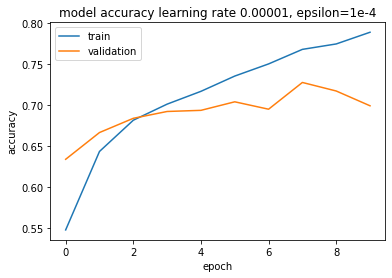

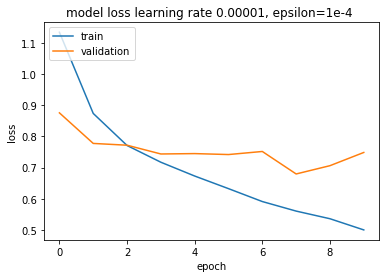

In [22]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy learning rate 0.00001, epsilon=1e-4',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss learning rate 0.00001, epsilon=1e-4 ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
# test with lr 0.00001 , epsilon= 1, default epsilon =1e-7
lr=0.00001
ep_=1
input_tensor=Input(shape=(224,224,3))
opt = keras.optimizers.Adam(lr, epsilon=ep_)
model=create_model(opt,input_tensor)
h=fit_model(model,bs, 10, "densenet_00001_ep_1")

Epoch 1/10
234/234 [==============================] - 389s 2s/step - loss: 1.7237 - accuracy: 0.3281 - val_loss: 1.5399 - val_accuracy: 0.3043
Epoch 2/10
234/234 [==============================] - 376s 2s/step - loss: 1.6625 - accuracy: 0.3441 - val_loss: 1.5181 - val_accuracy: 0.3419
Epoch 3/10
234/234 [==============================] - 377s 2s/step - loss: 1.5961 - accuracy: 0.3588 - val_loss: 1.4779 - val_accuracy: 0.3844
Epoch 4/10
234/234 [==============================] - 376s 2s/step - loss: 1.5342 - accuracy: 0.3818 - val_loss: 1.4468 - val_accuracy: 0.3865
Epoch 5/10
234/234 [==============================] - 384s 2s/step - loss: 1.4984 - accuracy: 0.3929 - val_loss: 1.3923 - val_accuracy: 0.4130
Epoch 6/10
234/234 [==============================] - 402s 2s/step - loss: 1.4539 - accuracy: 0.4110 - val_loss: 1.3081 - val_accuracy: 0.4408
Epoch 7/10
234/234 [==============================] - 401s 2s/step - loss: 1.3918 - accuracy: 0.4314 - val_loss: 1.3236 - val_accuracy: 0.4290

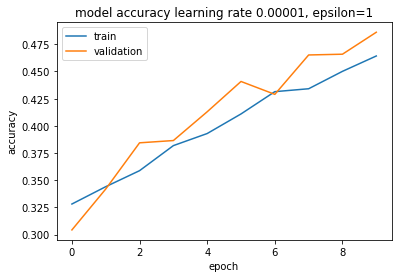

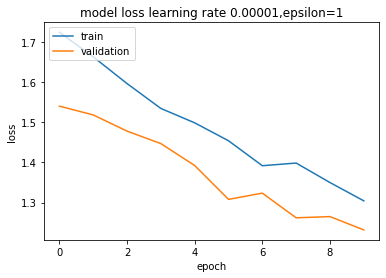

In [24]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy learning rate 0.00001, epsilon=1',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss learning rate 0.00001,epsilon=1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# test with lr 0.00001 , epsilon= 0.1, default epsilon =1e-7
lr = 0.00001
ep_= 0.1
input_tensor=Input(shape=(224,224,3))
opt = keras.optimizers.Adam(lr, epsilon=ep_)
model=create_model(opt,input_tensor)
h=fit_model(model,bs, 10, "densenet_00001_ep_01")

Epoch 1/10
234/234 [==============================] - 410s 2s/step - loss: 1.5573 - accuracy: 0.3774 - val_loss: 1.2504 - val_accuracy: 0.4513
Epoch 2/10
234/234 [==============================] - 414s 2s/step - loss: 1.3415 - accuracy: 0.4545 - val_loss: 1.1462 - val_accuracy: 0.5125
Epoch 3/10
234/234 [==============================] - 410s 2s/step - loss: 1.2168 - accuracy: 0.4992 - val_loss: 1.0935 - val_accuracy: 0.5327
Epoch 4/10
234/234 [==============================] - 410s 2s/step - loss: 1.1483 - accuracy: 0.5333 - val_loss: 1.0143 - val_accuracy: 0.5738
Epoch 5/10
234/234 [==============================] - 414s 2s/step - loss: 1.0855 - accuracy: 0.5514 - val_loss: 0.9615 - val_accuracy: 0.6017
Epoch 6/10
234/234 [==============================] - 395s 2s/step - loss: 1.0389 - accuracy: 0.5729 - val_loss: 0.9570 - val_accuracy: 0.6114
Epoch 7/10
234/234 [==============================] - 394s 2s/step - loss: 1.0041 - accuracy: 0.5858 - val_loss: 0.9163 - val_accuracy: 0.6288

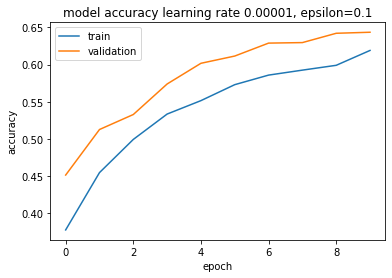

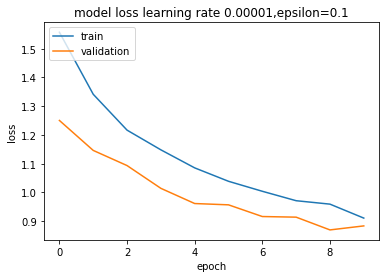

In [26]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy learning rate 0.00001, epsilon=0.1',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss learning rate 0.00001,epsilon=0.1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
# test with lr 0.00001 , epsilon= 1e-8, default epsilon =1e-7
lr=0.00001
ep_= 1e-8
input_tensor=Input(shape=(224,224,3))
opt = keras.optimizers.Adam(lr, epsilon=ep_)
model=create_model(opt,input_tensor)
h=fit_model(model,bs, 10, "densenet_00001_ep_00000001")

Epoch 1/10
234/234 [==============================] - 430s 2s/step - loss: 1.0707 - accuracy: 0.5609 - val_loss: 0.8142 - val_accuracy: 0.6532
Epoch 2/10
234/234 [==============================] - 430s 2s/step - loss: 0.8574 - accuracy: 0.6431 - val_loss: 0.8162 - val_accuracy: 0.6630
Epoch 3/10
234/234 [==============================] - 429s 2s/step - loss: 0.7623 - accuracy: 0.6804 - val_loss: 0.7763 - val_accuracy: 0.6776
Epoch 4/10
234/234 [==============================] - 426s 2s/step - loss: 0.6880 - accuracy: 0.7119 - val_loss: 0.7487 - val_accuracy: 0.6873
Epoch 5/10
234/234 [==============================] - 420s 2s/step - loss: 0.6419 - accuracy: 0.7228 - val_loss: 0.7756 - val_accuracy: 0.6957
Epoch 6/10
234/234 [==============================] - 426s 2s/step - loss: 0.6118 - accuracy: 0.7369 - val_loss: 0.7277 - val_accuracy: 0.6971
Epoch 7/10
234/234 [==============================] - 420s 2s/step - loss: 0.5727 - accuracy: 0.7615 - val_loss: 0.7416 - val_accuracy: 0.7019

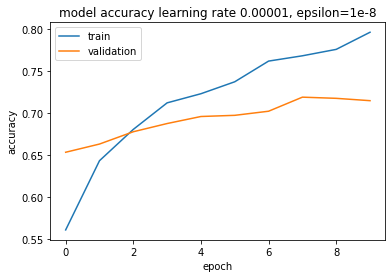

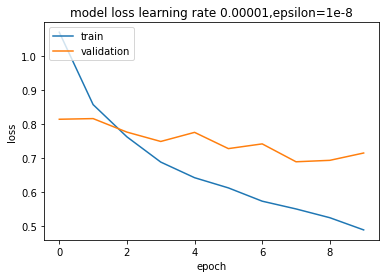

In [28]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy learning rate 0.00001, epsilon=1e-8',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss learning rate 0.00001,epsilon=1e-8')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
234/234 [==============================] - 452s 2s/step - loss: 1.1295 - accuracy: 0.5447 - val_loss: 0.8423 - val_accuracy: 0.6406
Epoch 2/10
234/234 [==============================] - 428s 2s/step - loss: 0.8565 - accuracy: 0.6447 - val_loss: 0.8095 - val_accuracy: 0.6637
Epoch 3/10
234/234 [==============================] - 412s 2s/step - loss: 0.7633 - accuracy: 0.6802 - val_loss: 0.8305 - val_accuracy: 0.6834
Epoch 4/10
234/234 [==============================] - 421s 2s/step - loss: 0.6925 - accuracy: 0.7049 - val_loss: 0.7669 - val_accuracy: 0.6889
Epoch 5/10
234/234 [==============================] - 433s 2s/step - loss: 0.6488 - accuracy: 0.7281 - val_loss: 0.7613 - val_accuracy: 0.6807
Epoch 6/10
234/234 [==============================] - 433s 2s/step - loss: 0.6088 - accuracy: 0.7442 - val_loss: 0.7392 - val_accuracy: 0.6977
Epoch 7/10
234/234 [==============================] - 439s 2s/step - loss: 0.5854 - accuracy: 0.7477 - val_loss: 0.7425 - val_accuracy: 0.7018

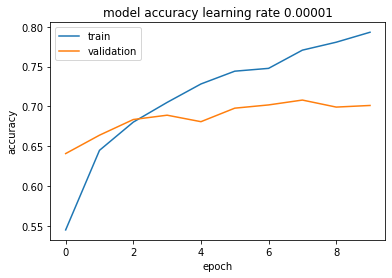

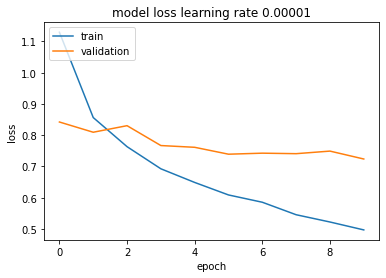

In [8]:
# test with lr 0.00001 , epsilon= 1e-8, default epsilon =1e-7
lr=0.00001
ep_= 1e-7
input_tensor=Input(shape=(224,224,3))
opt = keras.optimizers.Adam(lr)
model=create_model(opt,input_tensor)
h=fit_model(model,bs, 10, "densenet_00001")

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy learning rate 0.00001',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss learning rate 0.00001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()